# Prepare

In [35]:
from sympy.printing.numpy import const
from torch.backends.mkl import verbose
%load_ext autoreload
%autoreload 2


In [84]:
import numpy as np
import networkx as nx
import random, io


import os
import pickle


from expts.influence import influence
from expts.net_env import NetworkEnv

from rl_alg.replay import PriortizedReplay
from rl_alg.dqn import DQNTrainer
from rl_alg.utils import OrnsteinUhlenbeckActionNoise

from ge.models.deepwalk import DeepWalk

import tracemalloc
from multiprocessing import cpu_count
import gc
import torch
cpu_count()

20

In [55]:
g_paths = [
    'train_data/copen.pkl',
    'train_data/occupy.pkl',
    # 'train_data/assad.pkl',
    # 'train_data/obama.pkl',
]

syn = False
ratio = 5
os.makedirs("models", exist_ok=True)
os.makedirs("logs", exist_ok=True)

# 随机数选择
random.seed(10)
# args = arg_parse()
rg = np.random.RandomState(10)
rg1 = np.random.RandomState(10)



# 需要配置的超参数

# 查询预算
budget = 10

extra_seeds = 5
nop_reward = 0
times_mean_env = 5
step_reward = 0
bad_reward = 0
max_reward = None
min_reward = None
norm_reward = 0
BUFF_SIZE = 4000
const_features = 1 # 1 for constant features, 0 for node embeddings
action_dim = 60
if const_features:
    input_dim = 20
else:
    input_dim = action_dim + 2
    
    
# DQN
lr = 1e-4
LR = lr
eta = 0.1
gamma = 0.99
epsilon = 0.1
batch_size = 100

use_cuda = True
cpu = 0

# DeepWalk
walk_len = 10
num_walks = 80
win = 5
emb_iters = 50

gcn_layers = 2
num_pooling = 1
assign_dim = 100
assign_hidden_dim = 150

noise_momentum = 0.15
noise_magnitude = 0.2

eps = 10000

# Model
model_prefix = "2_trainset_"

# Load Graph

In [3]:
#generate graph
graphs = []
for g_path in g_paths:
    with open(g_path,'rb') as fl:
        graphs.append(pickle.load(fl))
    print(g_path)
    g = graphs[-1]
    print("Nodes: "+str(len(g))+' Edges: '+str(len(g.edges)))

train_data/copen.pkl
Nodes: 761 Edges: 1029
train_data/occupy.pkl
Nodes: 3225 Edges: 3944


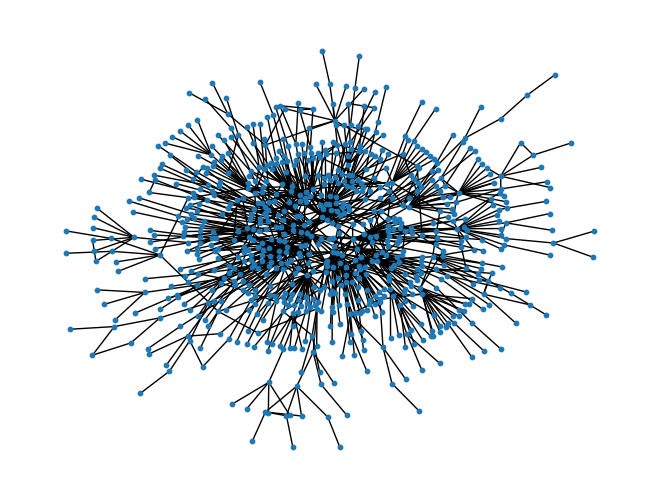

In [4]:
# 可视化
import matplotlib.pyplot as plt
for g in graphs:
    layout = nx.kamada_kawai_layout(g)
    nx.draw(g, with_labels=False, node_size=10, pos=layout)
    plt.show()
    break

## Calculate the best baseline

In [5]:
#Get best baseline
opts = []
for gp,g in zip(g_paths,graphs):
    # opt_obj, local_obj, S_opt = influence(g,g,args.weight_model)
    opt_obj, local_obj, S_opt = influence(g,g,"CONST")
    print(gp)
    print('OPT Results:'+str(opt_obj)+' '+ str(S_opt))
    opts.append(opt_obj)

train_data/copen.pkl
OPT Results:45.129999999999974 {228, 357, 136, 9, 396, 492, 692, 183, 377, 157}
train_data/occupy.pkl
OPT Results:143.75 {609, 513, 2981, 1573, 2054, 1065, 847, 2832, 2684, 671}


In [6]:
#Initialize seeds，随机选取extra_seeds个节点
e_seeds_list = []
for g in graphs:
    e_seeds_list.append(list(rg.choice(len(g), extra_seeds)))

# Initialize Environment

In [7]:
envs = []
for g,seeds in zip(graphs, e_seeds_list):
    env = NetworkEnv(fullGraph=g, seeds=seeds, opt_reward=0, nop_r=nop_reward,
                times_mean=times_mean_env, bad_reward=bad_reward, clip_max=max_reward, clip_min=min_reward ,normalize=norm_reward)
    envs.append(env)

In [8]:
replay = PriortizedReplay(BUFF_SIZE, 10, beta=0.6)

In [9]:
acmodel = DQNTrainer(input_dim=input_dim,state_dim=action_dim, action_dim=action_dim, replayBuff=replay, lr=LR, use_cuda=use_cuda, gamma=gamma,
                        eta=eta, gcn_num_layers=gcn_layers, num_pooling=num_pooling, assign_dim=assign_dim, assign_hidden_dim=assign_hidden_dim)

noise = OrnsteinUhlenbeckActionNoise(action_dim, theta=noise_momentum, sigma=noise_magnitude)


In [10]:
rws = []

In [11]:

# initialize node attribute
node_attrs = []
for g in graphs:
    n = len(g)
    mat = np.ones((n,input_dim))
    node_attrs.append(mat)
node_attrs

[array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]])]

In [91]:
def get_embeds(g):
    d={}
    for n in g.nodes:
        d[n]=str(n)
    g1 = nx.relabel_nodes(g,d)
    graph_model = DeepWalk(g1,num_walks= num_walks, walk_length=walk_len, workers=cpu if cpu>0 else cpu_count())
    
    graph_model.train(window_size = win, iter=emb_iters, embed_size=action_dim)
    embs = {}
    emb1 = graph_model.get_embeddings()
    for n in emb1.keys():
        embs[int(n)] = emb1[n]
    return embs

def get_action(s, emb,nodes):
    q_vals = -10000.0
    node = -1
    for v in nodes:
        value, _ = acmodel.get_values2_(s[0], s[1], emb[v])
        if value>q_vals:
            q_vals = value
            node = v
    return node, q_vals

def get_action_curr1(s, emb,nodes):
    q_vals = -10000.0
    node = -1
    for v in nodes:
        # Critic网络去评判当前节点的价值
        value, _ = acmodel.get_values2(s[0], s[1], emb[v])
        if value>q_vals:
            q_vals = value
            node = v
    return node, q_vals

def get_action_curr2(s, emb,nodes):
    q_vals = -10000.0
    node = -1
    for v in nodes:
        _, value = acmodel.get_values2(s[0], s[1], emb[v])
        if value>q_vals:
            q_vals = value
            node = v
    return node, q_vals

In [93]:
# try:
n_iter = 0

tracemalloc.start()
# start_ep = load_checkpoint(acmodel, args.model_prefix)
# ----------------
path = "models"
epochs = [int(i[len(model_prefix):-4]) for i in os.listdir(path) if i.startswith(model_prefix)]
latest = max(epochs)
model_path = '%s%d.pth' % (model_prefix, latest)
print(f"Loading model from {model_path}")
acmodel.load_models(model_path)
# ----------------
start_ep = latest
print(f"Starting from epoch {start_ep}")
start_ep += 1
for ep in range(start_ep, start_ep+eps):
    print(f"===========================Epoch: {ep}=================")
    # idx = rg1.randint(len(graphs))
    idx = 0
    env = envs[idx]
    g = graphs[idx]
    opt = opts[idx]
    node_attr = node_attrs[idx]
    
    res = []
    e_seeds = e_seeds_list[idx]
    env.reset(seeds=e_seeds)
    print(f"Seeds: {e_seeds}")
    # node_list为当前已经被激活的节点
    node_list = list(env.active.union(env.possible_actions))
    
    # 获取当前激活图的邻接矩阵
    t = env.state
    t0 = len(t)
    print(f"State: {t0}")
    # 获取当前激活图的节点embedding
    s_embs = get_embeds(env.sub)
    print(f"Embeddings: {len(s_embs)}")
    # 计算当前state
    if const_features:
        s = [node_attr[node_list], env.state]
    else:
        pass # TODO
    tot_r = 0
    tot_r1 = 0
    for steps in range(budget):
        print(f"**********Step: {steps}*************")
        # 获取当前可能的动作的idx
        possible_actions = [node_list.index(x) for x in env.possible_actions]
        state_embed, _ = acmodel.get_node_embeddings(nodes_attr=s[0], adj=s[1], nodes=possible_actions) # s[0]为节点属性，s[1]为邻接矩阵
        
        # 如果当前可选择的动作为空，则跳出循环
        l = list(env.possible_actions)
        if len(l) == 0: break
        # 如果大于epsilon，且replay的size大于batch_size或者是第一次迭代
        if rg1.rand() > epsilon and (replay.size > batch_size or ep == start_ep):
            if rg1.rand() > 0.5: # 保证策略的多样性
                actual_action, q = get_action_curr1(s,s_embs, l)
            else:
                actual_action, q = get_action_curr2(s,s_embs, l)
            proto_action = actual_action_embed = s_embs[actual_action]

        else: # 随机选择
            actual_action = rg1.choice(list(env.possible_actions), 1)[0]
            proto_action = actual_action_embed = s_embs[actual_action]
            
        res.append(actual_action)
        
        _, r, d, _ = env.step(actual_action)
        node_list = list(env.active.union(env.possible_actions))
        t = env.state
        s_embs = get_embeds(env.sub)
        if const_features:
            s1 = [node_attr[node_list], env.state]
        else:
            pass # TODO
        print(f"state: {len(t)}, action: {actual_action}, reward: {r}")
        if steps == budget-1 or len(env.possible_actions)==0:
            env.step(-1)
            r += env.reward
            d = True
        if d:
            s1[1] *= 0
        tot_r+=r
        t = len(env.state)
        r1=r+ (1/(len(g)))*(t-t0)
        t0 = t
        if d:
            r1 = r1 / opt
            
        tot_r1+=r1
        
        # TD Compute
        td = acmodel.td_compute(s,actual_action_embed, r1, s1, s_embs[get_action(s1, s_embs, env.possible_actions)[0]])
        replay.add(s,actual_action_embed, r1, s1,s_embs[get_action(s1, s_embs, env.possible_actions)[0]] , actual_action, td=np.abs(td))
        
        if (ep == start_ep and steps < 2) or replay.size>batch_size:
            acmodel.gradient_update_sarsa(batch_size=batch_size)
            acmodel.gradient_update_sarsa(batch_size=batch_size)
        torch.cuda.empty_cache()
        n_iter += 1
        
        s = s1
        if d:
            break
        
    print('Critic Loss:', acmodel.loss_critic)
    print('Action:', proto_action)
    print('Value:', q)
    print('Env Reward:', r1)
    print('Reward:', tot_r)
    print('Chosen:', res,'\n')
    print('Episode: '+str(ep)+' Reward: '+ str(tot_r))
    print('Critic Loss: '+ str(acmodel.loss_critic))
    rws.append(tot_r)
    current, peak = tracemalloc.get_traced_memory()
    print(f"Current memory usage is {current / 10 ** 6}MB; Peak was {peak / 10 ** 6}MB")
    gc.collect()
    break
# 抛出
# except Exception as e:
#     print(e)
#     print("Starting from scratch")


Loading model from 2_trainset_1200.pth
models loaded from models\2_trainset_1200.pth
Starting from epoch 1200
===========================Epoch: 1201=================
Seeds: [265, 125, 527, 320, 369]
State: 13
Learning embedding vectors...
Learning embedding vectors done!
Embeddings: 13
**********Step: 0*************
Learning embedding vectors...
Learning embedding vectors done!
state: 24, action: 244, reward: 0
**********Step: 1*************
Learning embedding vectors...
Learning embedding vectors done!
state: 35, action: 138, reward: 0
**********Step: 2*************
Learning embedding vectors...
Learning embedding vectors done!
state: 35, action: 634, reward: 0
**********Step: 3*************
Learning embedding vectors...
Learning embedding vectors done!
state: 42, action: 513, reward: 0
**********Step: 4*************
Learning embedding vectors...
Learning embedding vectors done!
state: 50, action: 24, reward: 0
**********Step: 5*************
Learning embedding vectors...
Learning embe

AttributeError: Can't pickle local object 'parallel_influence.<locals>.influence_wrapper'

In [81]:
res

[743]

Old nodes: 6, [320, 743, 265, 527, 369, 125]
Active nodes: 11, [513, 386, 450, 487, 394, 171, 403, 116, 244, 24, 157]


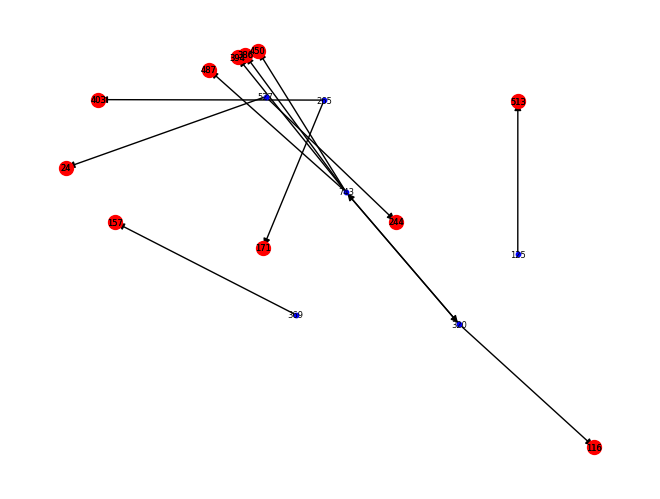

In [79]:
def vis(graph,new_active_nodes):
    # 只可视化有边的节点
    graph = graph.edge_subgraph(graph.edges)
    layout = nx.kamada_kawai_layout(graph)
    # 旧节点为蓝色，新节点为红色
    nx.draw(graph, with_labels=True, node_size=10, pos=layout, node_color='b', font_size=6)
    nx.draw(graph.subgraph(new_active_nodes), with_labels=True, node_size=100, pos=layout, node_color='r', font_size=6)
    # 旧节点
    old_list = list(set(graph.nodes).difference(set(new_active_nodes)))
    print(f"Old nodes: {len(old_list)}, {old_list}")
    print(f"Active nodes: {len(new_active_nodes)}, {new_active_nodes}")
    plt.show()
vis(env.graph, list(env.possible_actions))

In [16]:

env.active

{733, 1180, 1520, 2009, 3195}

In [51]:
if const_features:
    print(1)

1


In [56]:
env.possible_actions

{24, 116, 157, 171, 244, 403, 513, 743}

In [60]:
node_list

[320, 513, 743, 265, 171, 527, 369, 403, 116, 244, 157, 24, 125]

In [63]:
possible_actions

[1, 2, 4, 7, 8, 9, 11, 10]